# Create CIGALE input files
-----------------------------------------------

Here we create the photometry files that we use as an input to [CIGALE](https://cigale.lam.fr/).  

The code for creating the phot files was develoved by [Andrés Ramos](a.f.ramos.padilla@rug.nl ).

In [1]:
import numpy as np
import astropy.units as u

from astropy.table import Table, Column
from pathlib import Path
from matplotlib import pyplot as plt

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.container { font-size:18px !important; }</style>"))

In [2]:
path_raw='../Datos/Raw/'
path_phot_ned = '../Datos/Work/Phot_Tables_NED/' #In this path wi will save the photometry tables for each object
path_phot_cds = '../Datos/Work/Phot_Tables_CDS/'
path_SED = '../Datos/Work/SEDs/'
path_CIGALE_phot_Sy = '../Datos/Work/CIGALE_InputPhot_Sy/'
Path(path_CIGALE_phot_Sy).mkdir(parents=True, exist_ok=True)
path_FINAL = '../Datos/Final/'
Path(path_FINAL).mkdir(parents=True, exist_ok=True)

date_sample = 'Sep_02_2022'
date_sample_2 = 'May_29_2023'

NeIR_Sy_t = Table.read(path_raw+'Obj_Sy_Ne-IR_'+date_sample+'.vot',format='votable')
NeIR_QSO_t = Table.read(path_raw+'Obj_QSO_Ne-IR_'+date_sample_2+'.vot',format='votable')
print('Seyfert galaxies with Ne lines info:',len(NeIR_Sy_t))
print('QSO galaxies with Ne lines info:',len(NeIR_QSO_t))
#NeIR_obj_t.show_in_notebook()

Seyfert galaxies with Ne lines info: 303
QSO galaxies with Ne lines info: 18


## Create equivalences between NED and CDS tables
Here we create a list for the different names of the bands in NED and CDS. Each row represents the same band.

In [3]:
Equival = [['2-10 keV (XMM)', None, None],
           ['0.5-2 keV (XMM)', None, None],
           ['GALEX:FUV', 'FUV (GALEX)', None],
           ['GALEX:NUV', 'NUV (GALEX)', None],
           ["SDSS:u'", 'SDSS:u', 'u (SDSS) AB'],
           ["SDSS:g'", 'SDSS:g', 'g (SDSS) AB'],
           ["SDSS:r'", 'SDSS:r', 'r (SDSS) AB'],
           ["SDSS:i'", 'SDSS:i', 'i (SDSS) AB'],
           ["SDSS:z'", 'SDSS:z', 'z (SDSS) AB'],
           ['2MASS:J', 'J (2MASS) AB', None],
           ['2MASS:H', 'H (2MASS) AB', None],
           ['2MASS:Ks', 'Ks (2MASS) AB', None],
           ['WISE:W1', 'W1 (WISE)', None],
           [':=3.6um', '3.6 microns (IRAC)', None],
           [':=4.5um', '4.5 microns (IRAC)', None],
           ['WISE:W2', 'W2 (WISE)', None],
           [':=5.8um', '5.8 microns (IRAC)', None],
           [':=8um', '8.0 microns (IRAC)', None],
           ['IRAS:12', '12 microns (IRAS)', None],
           ['WISE:W3', 'W3 (WISE)', None],
           ['WISE:W4', 'W4 (WISE)', None],
           ['Spitzer/MIPS:24', '24 microns (MIPS)', None],
           ['IRAS:25', '25 microns (IRAS)', None],
           ['IRAS:60', '60 microns (IRAS)', None],
           ['Herschel/PACS:70', '70 microns (PACS)', None],
           ['Spitzer/MIPS:70', '70 microns (MIPS)', None],
           ['IRAS:100', '100 microns (IRAS)', None],
           ['Herschel/PACS:100', '100 microns (PACS)', None],
           ['Spitzer/MIPS:160', '160 microns (MIPS)', None],
           ['Herschel/PACS:160', '160 microns (PACS)', None],
           ['Herschel/SPIRE:250', '250 microns (SPIRE)', ':=250um'],
           ['Herschel/SPIRE:350', '350 microns (SPIRE)', ':=350um'],
           ['Herschel/SPIRE:500', '500 microns (SPIRE)', ':=500um'],
           [':=5GHz', ':=6cm', '4.89 GHz (VLA)'],
           [':=1.5GHz', ':=20cm', '1.46 GHz (VLA)'],
           [':=1.4GHz', ':=21cm', '1.4GHz']]

## Transforming photometry to CIGALE table

The next class allows us to transform the units of the SEDs in the selected bands.

In [4]:
class TransformCIGALE:
    """Class to plot the SEDs and create a row with the right units"""
    def __init__(self, sed):
        self.sed = sed
        #self.init_plot() # To check the SED
        self.create_row()

    def init_plot(self):
        "Plot the SED"
        plt.errorbar(self.sed['Wave'], self.sed['Flux']*1000, yerr=self.sed['F_er']*1000, fmt='o')
        plt.xlim(1e-6, 1e6)
        plt.loglog()

    def create_row(self):
        """Calculate the flux and error to use for the SED in CIGALE"""
        # Number of filtets/bands and their errors
        self.row = np.full(72, np.nan)
        iband = 0
        for band in Equival:
            crop = self.sed[np.logical_or.reduce([self.sed['Filter'] == band[0],
                                                  self.sed['Filter'] == band[1],
                                                  self.sed['Filter'] == band[2]])]
            flux = np.mean(crop['Flux'])
            std = np.sqrt(np.sum(crop['F_er']**2))/len(crop)
            self.row[iband] = flux*1000  # To send in mJy
            self.row[iband+1] = std*1000  # To send in mJy
            iband += 2

We create a table with all the CIGALE bands/filters and fill it with the information that we get from NED and CDS. In some cases some of the galaxies are not useful because the bands are not found initially. This could take some minutes.

In [5]:
CIGALEFilter = ['xray_box_car_2to10keV', 'xray_box_car_0p5to2keV', 'FUV', 'NUV',
                'u_prime', 'g_prime', 'r_prime', 'i_prime', 'z_prime', 'J_2mass',
                'H_2mass', 'Ks_2mass', 'WISE1', 'IRAC1', 'IRAC2', 'WISE2', 'IRAC3', 'IRAC4',
                'IRAS1', 'WISE3', 'WISE4', 'MIPS1', 'IRAS2', 'IRAS3', 'PACS_blue', 'MIPS2',
                'IRAS4', 'PACS_green', 'MIPS3', 'PACS_red', 'PSW_ext', 'PMW_ext', 'PLW_ext',
                'VLA_C', 'VLA_L', 'HI21cm']
# VLAC is 6cm ,VLAL is 20 cm and HI21cm is 1.4GHz
CIGFilt = [[filt, filt+'_err'] for filt in CIGALEFilter]

In [6]:
CIG_Sy = Table(names=np.array(CIGFilt).ravel())
GoodGalaxies_Sy = []

for igal, Galaxy in enumerate(NeIR_Sy_t['Main_Id']):
    #     figure()
    try:
        sed_file = Table.read(path_SED+Galaxy + '_Phot.txt',
                          format='ascii')
        if len(sed_file) == 0:
            print(Galaxy, igal, 'No useful phot.')
        else:
            GoodGalaxies_Sy.append(igal)
            CIG_Sy.add_row(TransformCIGALE(sed_file).row)
    except FileNotFoundError:
        print(Galaxy, igal, 'No Phot. ERROR')

/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_11152/1215562341.py:24: RuntimeWarning: invalid value encountered in double_scalars
  std = np.sqrt(np.sum(crop['F_er']**2))/len(crop)


In [7]:
CIG_QSO = Table(names=np.array(CIGFilt).ravel())
GoodGalaxies_QSO = []

for igal, Galaxy in enumerate(NeIR_QSO_t['Main_Id']):
    #     figure()
    try:
        sed_file = Table.read(path_SED+Galaxy + '_Phot.txt',
                          format='ascii')
        if len(sed_file) == 0:
            print(Galaxy, igal, 'No useful phot.')
        else:
            GoodGalaxies_QSO.append(igal)
            CIG_QSO.add_row(TransformCIGALE(sed_file).row)
    except FileNotFoundError:
        print(Galaxy, igal, 'No Phot. ERROR')

/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_11152/1215562341.py:24: RuntimeWarning: invalid value encountered in double_scalars
  std = np.sqrt(np.sum(crop['F_er']**2))/len(crop)


The next cell is just to print a SED

/tmp/ipykernel_11152/1215562341.py:24: RuntimeWarning: invalid value encountered in double_scalars
  std = np.sqrt(np.sum(crop['F_er']**2))/len(crop)


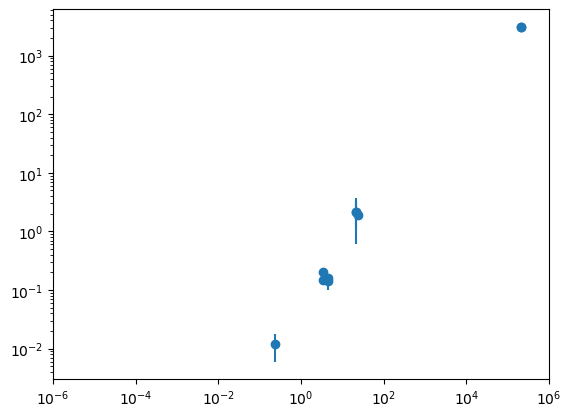

In [8]:
Gal = '3C 263.1'
sed_file = Table.read(path_SED+Gal + '_Phot.txt',
                          format='ascii')
TC=TransformCIGALE(sed_file)
TC.init_plot()

In [9]:
CIG_Sy.colnames

['xray_box_car_2to10keV',
 'xray_box_car_2to10keV_err',
 'xray_box_car_0p5to2keV',
 'xray_box_car_0p5to2keV_err',
 'FUV',
 'FUV_err',
 'NUV',
 'NUV_err',
 'u_prime',
 'u_prime_err',
 'g_prime',
 'g_prime_err',
 'r_prime',
 'r_prime_err',
 'i_prime',
 'i_prime_err',
 'z_prime',
 'z_prime_err',
 'J_2mass',
 'J_2mass_err',
 'H_2mass',
 'H_2mass_err',
 'Ks_2mass',
 'Ks_2mass_err',
 'WISE1',
 'WISE1_err',
 'IRAC1',
 'IRAC1_err',
 'IRAC2',
 'IRAC2_err',
 'WISE2',
 'WISE2_err',
 'IRAC3',
 'IRAC3_err',
 'IRAC4',
 'IRAC4_err',
 'IRAS1',
 'IRAS1_err',
 'WISE3',
 'WISE3_err',
 'WISE4',
 'WISE4_err',
 'MIPS1',
 'MIPS1_err',
 'IRAS2',
 'IRAS2_err',
 'IRAS3',
 'IRAS3_err',
 'PACS_blue',
 'PACS_blue_err',
 'MIPS2',
 'MIPS2_err',
 'IRAS4',
 'IRAS4_err',
 'PACS_green',
 'PACS_green_err',
 'MIPS3',
 'MIPS3_err',
 'PACS_red',
 'PACS_red_err',
 'PSW_ext',
 'PSW_ext_err',
 'PMW_ext',
 'PMW_ext_err',
 'PLW_ext',
 'PLW_ext_err',
 'VLA_C',
 'VLA_C_err',
 'VLA_L',
 'VLA_L_err',
 'HI21cm',
 'HI21cm_err']

In [10]:
CIG_QSO.colnames

['xray_box_car_2to10keV',
 'xray_box_car_2to10keV_err',
 'xray_box_car_0p5to2keV',
 'xray_box_car_0p5to2keV_err',
 'FUV',
 'FUV_err',
 'NUV',
 'NUV_err',
 'u_prime',
 'u_prime_err',
 'g_prime',
 'g_prime_err',
 'r_prime',
 'r_prime_err',
 'i_prime',
 'i_prime_err',
 'z_prime',
 'z_prime_err',
 'J_2mass',
 'J_2mass_err',
 'H_2mass',
 'H_2mass_err',
 'Ks_2mass',
 'Ks_2mass_err',
 'WISE1',
 'WISE1_err',
 'IRAC1',
 'IRAC1_err',
 'IRAC2',
 'IRAC2_err',
 'WISE2',
 'WISE2_err',
 'IRAC3',
 'IRAC3_err',
 'IRAC4',
 'IRAC4_err',
 'IRAS1',
 'IRAS1_err',
 'WISE3',
 'WISE3_err',
 'WISE4',
 'WISE4_err',
 'MIPS1',
 'MIPS1_err',
 'IRAS2',
 'IRAS2_err',
 'IRAS3',
 'IRAS3_err',
 'PACS_blue',
 'PACS_blue_err',
 'MIPS2',
 'MIPS2_err',
 'IRAS4',
 'IRAS4_err',
 'PACS_green',
 'PACS_green_err',
 'MIPS3',
 'MIPS3_err',
 'PACS_red',
 'PACS_red_err',
 'PSW_ext',
 'PSW_ext_err',
 'PMW_ext',
 'PMW_ext_err',
 'PLW_ext',
 'PLW_ext_err',
 'VLA_C',
 'VLA_C_err',
 'VLA_L',
 'VLA_L_err',
 'HI21cm',
 'HI21cm_err']

In [11]:
print('Percentage of Seyfert galaxies with xray_box_car_2to10keV data:',
      sum(~np.isnan(CIG_Sy[CIG_Sy.colnames[0]].data))/len(CIG_Sy))
print('Percentage of Seyfert galaxies with xray_box_car_0p5to2keV data:',
      sum(~np.isnan(CIG_Sy[CIG_Sy.colnames[3]].data))/len(CIG_Sy))

Percentage of Seyfert galaxies with xray_box_car_2to10keV data: 0.30033003300330036
Percentage of Seyfert galaxies with xray_box_car_0p5to2keV data: 0.24422442244224424


In [12]:
print('Percentage of Seyfert galaxies with VLA_C data:',
      sum(~np.isnan(CIG_Sy[CIG_Sy.colnames[66]].data))/len(CIG_Sy))
print('Percentage of Seyfert galaxies with VLA_L data:',
      sum(~np.isnan(CIG_Sy[CIG_Sy.colnames[68]].data))/len(CIG_Sy))
print('Percentage of Seyfert galaxies with HI21cm data:',
      sum(~np.isnan(CIG_Sy[CIG_Sy.colnames[70]].data))/len(CIG_Sy))

Percentage of Seyfert galaxies with VLA_C data: 0.11551155115511551
Percentage of Seyfert galaxies with VLA_L data: 0.07920792079207921
Percentage of Seyfert galaxies with HI21cm data: 0.7623762376237624


In [13]:
print('Percentage of QSO galaxies with xray_box_car_2to10keV data:',
      sum(~np.isnan(CIG_QSO[CIG_QSO.colnames[0]].data))/len(CIG_QSO))
print('Percentage of QSO galaxies with xray_box_car_0p5to2keV data:',
      sum(~np.isnan(CIG_QSO[CIG_QSO.colnames[3]].data))/len(CIG_QSO))

Percentage of QSO galaxies with xray_box_car_2to10keV data: 0.05555555555555555
Percentage of QSO galaxies with xray_box_car_0p5to2keV data: 0.05555555555555555


In [14]:
print('Percentage of QSO galaxies with VLA_C data:',
      sum(~np.isnan(CIG_QSO[CIG_QSO.colnames[66]].data))/len(CIG_QSO))
print('Percentage of QSO galaxies with VLA_L data:',
      sum(~np.isnan(CIG_QSO[CIG_QSO.colnames[68]].data))/len(CIG_QSO))
print('Percentage of QSO galaxies with HI21cm data:',
      sum(~np.isnan(CIG_QSO[CIG_QSO.colnames[70]].data))/len(CIG_QSO))

Percentage of QSO galaxies with VLA_C data: 0.0
Percentage of QSO galaxies with VLA_L data: 0.0
Percentage of QSO galaxies with HI21cm data: 0.4444444444444444


In [15]:
CIG_Sy = CIG_Sy[CIG_Sy.colnames[4:-6]]  # Remove x-ray and radio wavelengths
CIG_QSO = CIG_QSO[CIG_QSO.colnames[4:-6]]  # Remove x-ray and radio wavelengths

We add the identifier (main_id) and the redshift from SIMBAD.

In [16]:
Sy_col_name = Column(name='id', data=NeIR_Sy_t['Main_Id'][GoodGalaxies_Sy])
CIG_Sy.add_column(Sy_col_name, 0)
Sy_col_z = Column(name='redshift', data=NeIR_Sy_t['redshift'][GoodGalaxies_Sy])
CIG_Sy.add_column(Sy_col_z, 1)

In [17]:
QSO_col_name = Column(name='id', data=NeIR_QSO_t['Main_Id'][GoodGalaxies_QSO])
CIG_QSO.add_column(QSO_col_name, 0)
QSO_col_z = Column(name='redshift', data=NeIR_QSO_t['redshift'][GoodGalaxies_QSO])
CIG_QSO.add_column(QSO_col_z, 1)

In [18]:
#CIG_Sy.show_in_notebook()

## Clean photometric values

Then, for each filter, we verify if the relative error is higher than 33%, in those cases we do not use that information for the modeling. In addition, we remove information with limits, that in some cases are annotated as negative values.

In [19]:
for igal in range(len(CIG_Sy)):
    for icol in CIG_Sy.colnames[2::2]:
        if CIG_Sy[icol+'_err'][igal]/CIG_Sy[icol][igal] >= 1/3.:  # Higher than 33%
            print('Idx:',igal,CIG_Sy['id'][igal], icol, CIG_Sy[icol+'_err'][igal]/CIG_Sy[icol][igal])
            CIG_Sy[icol+'_err'][igal] = np.nan
            CIG_Sy[icol][igal] = np.nan
        if CIG_Sy[icol+'_err'][igal]/CIG_Sy[icol][igal] <= 0:  # Negative Limits
            print('Idx:',igal,'Negative', CIG_Sy['id'][igal], icol)
            CIG_Sy[icol+'_err'][igal] = np.nan
            CIG_Sy[icol][igal] = np.nan

Idx: 1 2MASS J13000535+1632148 FUV 0.4492512399613503
Idx: 4 NGC  4945 H_2mass 0.34200465652699563
Idx: 8 LEDA   45656 IRAS3 0.4358974358974359
Idx: 8 LEDA   45656 IRAS4 0.33548387096774196
Idx: 13 LEDA 3095998 H_2mass 0.3611261953891703
Idx: 13 LEDA 3095998 Ks_2mass 0.4049506150848603
Idx: 13 LEDA 3095998 WISE4 0.4394152443038262
Idx: 13 LEDA 3095998 PSW_ext 0.4003778774826832
Idx: 15 NGC  4477 IRAC3 20.779224522371056
Idx: 16 LEDA   89511 FUV 0.3487694417282854
Idx: 18 Mrk  493 IRAS1 0.35659711704621994
Idx: 21 2MASS J22255427+1958370 NUV 0.6543330714654052
Idx: 21 2MASS J22255427+1958370 H_2mass 0.3977961022174125
Idx: 24 [VV2000] J235225.0+244009 J_2mass 0.44079420615248804
Idx: 25 3C 196 H_2mass 0.6532557650937084
Idx: 26 2MASX J10032788+5541535 FUV 0.3700046809357876
Idx: 26 2MASX J10032788+5541535 J_2mass 0.4372501858121231
Idx: 26 2MASX J10032788+5541535 H_2mass 0.5034755461676497
Idx: 26 2MASX J10032788+5541535 Ks_2mass 0.5585180838315121
Idx: 29 IRAS 11215-2806 FUV 0.65966116

In [20]:
for igal in range(len(CIG_QSO)):
    for icol in CIG_QSO.colnames[2::2]:
        if CIG_QSO[icol+'_err'][igal]/CIG_QSO[icol][igal] >= 1/3.:  # Higher than 33%
            print('Idx:',igal,CIG_QSO['id'][igal], icol, CIG_QSO[icol+'_err'][igal]/CIG_QSO[icol][igal])
            CIG_QSO[icol+'_err'][igal] = np.nan
            CIG_QSO[icol][igal] = np.nan
        if CIG_QSO[icol+'_err'][igal]/CIG_QSO[icol][igal] <= 0:  # Negative Limits
            print('Idx:',igal,'Negative', CIG_QSO['id'][igal], icol)
            CIG_QSO[icol+'_err'][igal] = np.nan
            CIG_QSO[icol][igal] = np.nan

Idx: 2 2MASS J17193331+5927430 J_2mass 0.3641988350637688
Idx: 3 3C 263.1 NUV 0.4965407070584316
Idx: 3 3C 263.1 WISE4 0.43344860479296626
Idx: 4 QSO B0125-0635 Ks_2mass 0.35804021519195117
Idx: 6 2MASS J09215939+4509126 J_2mass 0.3663468617444291
Idx: 6 2MASS J09215939+4509126 H_2mass 0.5948566601700208
Idx: 6 2MASS J09215939+4509126 Ks_2mass 0.5661444094491621
Idx: 7 [VV2000] J201329.8-414735 H_2mass 0.38902405723289113
Idx: 8 2MASS J03485764+1255473 J_2mass 0.41713145372552707
Idx: 9 2MASS J14363195+3438292 NUV 0.5402370852628753
Idx: 10 3C 244.1 FUV 0.3822320613808703
Idx: 10 3C 244.1 NUV 0.549745251590095
Idx: 14 3C 275.1 FUV 0.3491194783075816
Idx: 14 3C 275.1 J_2mass 0.43998958830080853
Idx: 14 3C 275.1 H_2mass 0.5786451493119278
Idx: 14 3C 275.1 Ks_2mass 0.3969587157688649
Idx: 14 3C 275.1 MIPS2 0.4525519081537707
Idx: 16 2MASS J00505570+2933281 FUV 0.6220881066940204
Idx: 16 2MASS J00505570+2933281 NUV 0.7645832549299972
Idx: 17 3C 254 H_2mass 0.4164015480517834
Idx: 17 3C 254

We define a minimum error for each filter to avoid overfitting

In [21]:
def add_min_err(phot_tab, list_bands, error):
    """Function to add a minimum error for the bands"""
    for col in list_bands:
        rel_error = phot_tab[col+'_err']/phot_tab[col]
        phot_tab[col+'_err'] = np.fmax(rel_error, error)*phot_tab[col]

In [22]:
add_min_err(CIG_Sy, ['FUV', 'NUV'], 0.1)
add_min_err(CIG_Sy, ['u_prime', 'g_prime', 'r_prime', 'i_prime', 'z_prime'], 0.02)
add_min_err(CIG_Sy, ['J_2mass', 'H_2mass', 'Ks_2mass'], 0.02)
add_min_err(CIG_Sy, ['IRAC1', 'IRAC2', 'IRAC3', 'IRAC4'], 0.03)
add_min_err(CIG_Sy, ['MIPS1', 'MIPS2', 'MIPS3'], 0.04)
add_min_err(CIG_Sy, ['WISE1', 'WISE2', 'WISE3', 'WISE4'], 0.06)
add_min_err(CIG_Sy, ['PACS_blue', 'PACS_green', 'PACS_red'], 0.1)
add_min_err(CIG_Sy, ['PSW_ext', 'PMW_ext', 'PLW_ext'], 0.07)

In [23]:
add_min_err(CIG_QSO, ['FUV', 'NUV'], 0.1)
add_min_err(CIG_QSO, ['u_prime', 'g_prime', 'r_prime', 'i_prime', 'z_prime'], 0.02)
add_min_err(CIG_QSO, ['J_2mass', 'H_2mass', 'Ks_2mass'], 0.02)
add_min_err(CIG_QSO, ['IRAC1', 'IRAC2', 'IRAC3', 'IRAC4'], 0.03)
add_min_err(CIG_QSO, ['MIPS1', 'MIPS2', 'MIPS3'], 0.04)
add_min_err(CIG_QSO, ['WISE1', 'WISE2', 'WISE3', 'WISE4'], 0.06)
add_min_err(CIG_QSO, ['PACS_blue', 'PACS_green', 'PACS_red'], 0.1)
add_min_err(CIG_QSO, ['PSW_ext', 'PMW_ext', 'PLW_ext'], 0.07)

In [24]:
CIG_Sy[32]

id,redshift,FUV,FUV_err,NUV,NUV_err,u_prime,u_prime_err,g_prime,g_prime_err,r_prime,r_prime_err,i_prime,i_prime_err,z_prime,z_prime_err,J_2mass,J_2mass_err,H_2mass,H_2mass_err,Ks_2mass,Ks_2mass_err,WISE1,WISE1_err,IRAC1,IRAC1_err,IRAC2,IRAC2_err,WISE2,WISE2_err,IRAC3,IRAC3_err,IRAC4,IRAC4_err,IRAS1,IRAS1_err,WISE3,WISE3_err,WISE4,WISE4_err,MIPS1,MIPS1_err,IRAS2,IRAS2_err,IRAS3,IRAS3_err,PACS_blue,PACS_blue_err,MIPS2,MIPS2_err,IRAS4,IRAS4_err,PACS_green,PACS_green_err,MIPS3,MIPS3_err,PACS_red,PACS_red_err,PSW_ext,PSW_ext_err,PMW_ext,PMW_ext_err,PLW_ext,PLW_ext_err
object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
NAME Circinus Galaxy,0.0014490516114409324,nan,nan,nan,nan,nan,nan,10.999999940395355,0.2199999988079071,44.50000077486038,2.0,103.00000011920929,3.0,nan,nan,nan,nan,nan,nan,nan,nan,3831.3888799614374,678.8486819545356,nan,nan,nan,nan,4259.611121575038,954.676033627535,nan,nan,nan,nan,18800.0,752.0,nan,nan,53756.24990463257,3225.374994277954,nan,nan,68400.00076293945,1923.3824372703418,249000.0,17642.34961676023,nan,nan,nan,nan,316000.0,31600.0,nan,nan,nan,nan,nan,nan,184000.0,21000.0,nan,nan,24100.000381469727,2900.0


In [25]:
CIG_QSO[0]

id,redshift,FUV,FUV_err,NUV,NUV_err,u_prime,u_prime_err,g_prime,g_prime_err,r_prime,r_prime_err,i_prime,i_prime_err,z_prime,z_prime_err,J_2mass,J_2mass_err,H_2mass,H_2mass_err,Ks_2mass,Ks_2mass_err,WISE1,WISE1_err,IRAC1,IRAC1_err,IRAC2,IRAC2_err,WISE2,WISE2_err,IRAC3,IRAC3_err,IRAC4,IRAC4_err,IRAS1,IRAS1_err,WISE3,WISE3_err,WISE4,WISE4_err,MIPS1,MIPS1_err,IRAS2,IRAS2_err,IRAS3,IRAS3_err,PACS_blue,PACS_blue_err,MIPS2,MIPS2_err,IRAS4,IRAS4_err,PACS_green,PACS_green_err,MIPS3,MIPS3_err,PACS_red,PACS_red_err,PSW_ext,PSW_ext_err,PMW_ext,PMW_ext_err,PLW_ext,PLW_ext_err
object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
QSO B1549-790,0.15,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.2700000079348683,0.22627416,2.8800000436604023,0.3642801,7.350000087171793,0.47623530000000003,22.58333358218272,1.3550000149309631,nan,nan,nan,nan,35.316666795810065,2.1190000077486038,nan,nan,nan,nan,120.99999967217445,14.673530590829188,110.43333419164021,6.626000051498413,408.9666717449824,24.538000304698944,435.9999895095825,17.4399995803833,477.4999986886978,22.701420105513936,1042.499998807907,62.06611469951137,nan,nan,nan,nan,1899.999976158142,360.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


-------------------
## Remove galaxies without energy balance

Then, we look for galaxies where the energy balance cannot be well constrained (i.e. galaxies where there is not enough bands in the optical and IR wavelengths).

In [26]:
BadGalaxies_Sy = []
for igal, Lrow in enumerate(CIG_Sy):
    IRPhotPoints_Sy = sum(~np.isnan(list(Lrow.as_void())[22:]))/2  # From WISE to PLW
    OpPhotPoints_Sy = sum(~np.isnan(list(Lrow.as_void())[2:22]))/2  # From FUV to Ks
    if IRPhotPoints_Sy < 3 or OpPhotPoints_Sy < 5:
         print('Galaxy %s has %i useful photometry points' %
               (Lrow['id'], IRPhotPoints_Sy+OpPhotPoints_Sy))
         BadGalaxies_Sy.append(igal)

Galaxy NGC  4945 has 15 useful photometry points
Galaxy NAME 3C 330G2 has 6 useful photometry points
Galaxy 2MASS J22255427+1958370 has 8 useful photometry points
Galaxy LEDA   90196 has 12 useful photometry points
Galaxy MCG+04-48-002 has 22 useful photometry points
Galaxy [VV2000] J235225.0+244009 has 10 useful photometry points
Galaxy 3C 196 has 10 useful photometry points
Galaxy NAME Circinus Galaxy has 12 useful photometry points
Galaxy Mrk  463E has 13 useful photometry points
Galaxy NGC  1365 has 22 useful photometry points
Galaxy LEDA   27453 has 12 useful photometry points
Galaxy NAME Cyg A has 11 useful photometry points
Galaxy IRAS 11119+3257 has 14 useful photometry points
Galaxy 2MASS J14533151+1353587 has 13 useful photometry points
Galaxy 2C 1066 has 8 useful photometry points
Galaxy ICRF J054236.1+495107 has 9 useful photometry points
Galaxy 2MASS J10520202+5633010 has 10 useful photometry points
Galaxy 3C 343.1 has 3 useful photometry points
Galaxy ICRF J145907.5+71401

In [27]:
BadGalaxies_QSO = []
for igal, Lrow in enumerate(CIG_QSO):
    IRPhotPoints_QSO = sum(~np.isnan(list(Lrow.as_void())[22:]))/2  # From WISE to PLW
    OpPhotPoints_QSO = sum(~np.isnan(list(Lrow.as_void())[2:22]))/2  # From FUV to Ks
    if IRPhotPoints_QSO < 3 or OpPhotPoints_QSO < 5:
         print('Galaxy %s has %i useful photometry points' %
               (Lrow['id'], IRPhotPoints_QSO+OpPhotPoints_QSO))
         BadGalaxies_QSO.append(igal)

Galaxy QSO B1549-790 has 12 useful photometry points
Galaxy 2MASS J17193331+5927430 has 18 useful photometry points
Galaxy 3C 263.1 has 3 useful photometry points
Galaxy [VV2000] J201329.8-414735 has 15 useful photometry points
Galaxy 2MASS J03485764+1255473 has 9 useful photometry points
Galaxy 2MASS J14363195+3438292 has 15 useful photometry points
Galaxy 3C 244.1 has 12 useful photometry points
Galaxy 2MASS J17144277+2602485 has 9 useful photometry points
Galaxy MCG+07-29-060 has 11 useful photometry points
Galaxy 3C 275.1 has 10 useful photometry points
Galaxy 2MASS J01572105+1712484 has 9 useful photometry points
Galaxy 2MASS J00505570+2933281 has 9 useful photometry points
Galaxy 3C 254 has 9 useful photometry points


In [28]:
print('The total Seyfert galaxies to remove are %d'%len(BadGalaxies_Sy))
print('The total QSO galaxies to remove are %d'%len(BadGalaxies_QSO))

The total Seyfert galaxies to remove are 51
The total QSO galaxies to remove are 13


To complement this information we plot the total photometry points in the `BadGalaxies`.

For the case of Seyfert Galaxies:

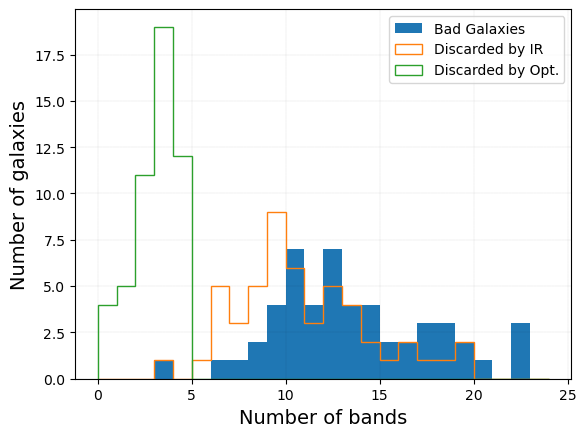

In [29]:
Tpins_Sy = []
TpinsIR_Sy = []
TpinsOp_Sy = []
for Lrow in CIG_Sy[BadGalaxies_Sy]:
    # All the bad galaxies
    Tpins_Sy.append(sum(~np.isnan(list(Lrow.as_void())[2:]))/2)
    # Galaxies discarded due to IR wavelegnths
    TpinsIR_Sy.append(sum(~np.isnan(list(Lrow.as_void())[22:]))/2)
    # Galaxies discarded due to Opt. wavelengths
    TpinsOp_Sy.append(sum(~np.isnan(list(Lrow.as_void())[2:22]))/2)
plt.hist(Tpins_Sy, bins=np.linspace(0, 24, 25), label='Bad Galaxies')
plt.hist(TpinsIR_Sy, bins=np.linspace(0, 24, 25),
         histtype='step', label='Discarded by IR')
plt.hist(TpinsOp_Sy, bins=np.linspace(0, 24, 25),
         histtype='step', label='Discarded by Opt.')
plt.ylabel('Number of galaxies',fontsize=14)
plt.xlabel('Number of bands',fontsize=14)
plt.grid(color='k', linestyle='--', linewidth=0.05)
plt.legend()

Most of the `BadGalaxies` are located in a large range of redshifts, mainly affecting galaxies at redshifts above $z=0.5$. This means that some of these galaxies are not well covered in some of the selected instruments and/or that the photometric values are not well constrained.

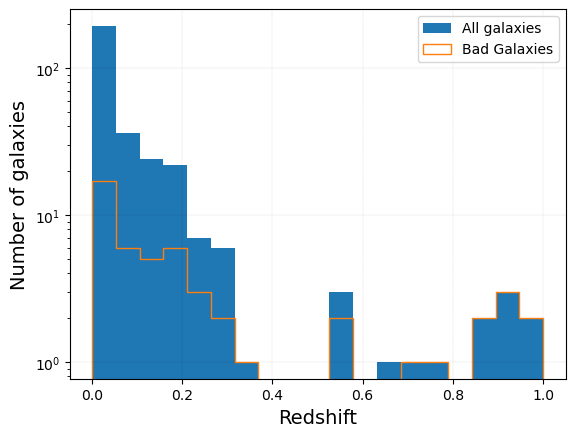

In [30]:
Redbins = np.linspace(0, 1.0, 20)
plt.hist(CIG_Sy['redshift'], bins=Redbins, label='All galaxies')
plt.hist(CIG_Sy[BadGalaxies_Sy]['redshift'], bins=Redbins, histtype='step', label='Bad Galaxies')
plt.xlabel('Redshift',fontsize=14)
plt.ylabel('Number of galaxies',fontsize=14)
plt.yscale('log')
plt.grid(color='k', linestyle='--', linewidth=0.05)
plt.legend()

For the case of QSO Galaxies:

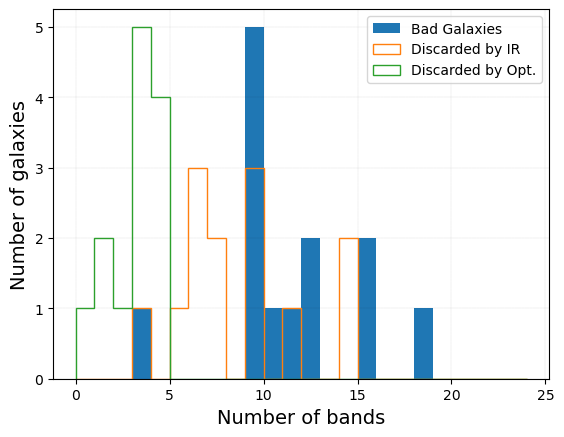

In [31]:
Tpins_QSO = []
TpinsIR_QSO = []
TpinsOp_QSO = []
for Lrow in CIG_QSO[BadGalaxies_QSO]:
    # All the bad galaxies
    Tpins_QSO.append(sum(~np.isnan(list(Lrow.as_void())[2:]))/2)
    # Galaxies discarded due to IR wavelegnths
    TpinsIR_QSO.append(sum(~np.isnan(list(Lrow.as_void())[22:]))/2)
    # Galaxies discarded due to Opt. wavelengths
    TpinsOp_QSO.append(sum(~np.isnan(list(Lrow.as_void())[2:22]))/2)
plt.hist(Tpins_QSO, bins=np.linspace(0, 24, 25), label='Bad Galaxies')
plt.hist(TpinsIR_QSO, bins=np.linspace(0, 24, 25),
         histtype='step', label='Discarded by IR')
plt.hist(TpinsOp_QSO, bins=np.linspace(0, 24, 25),
         histtype='step', label='Discarded by Opt.')
plt.ylabel('Number of galaxies',fontsize=14)
plt.xlabel('Number of bands',fontsize=14)
plt.grid(color='k', linestyle='--', linewidth=0.05)
plt.legend()

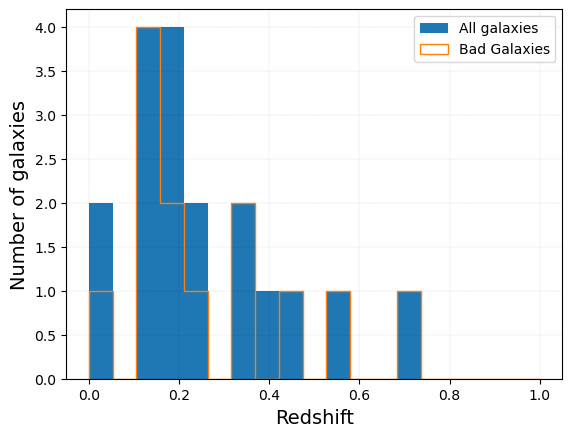

In [32]:
Redbins = np.linspace(0, 1.0, 20)
plt.hist(CIG_QSO['redshift'], bins=Redbins, label='All galaxies')
plt.hist(CIG_QSO[BadGalaxies_QSO]['redshift'], bins=Redbins, histtype='step', label='Bad Galaxies')
plt.xlabel('Redshift',fontsize=14)
plt.ylabel('Number of galaxies',fontsize=14)
#plt.yscale('log')
plt.grid(color='k', linestyle='--', linewidth=0.05)
plt.legend()

We save in a different file those galaxies that do not fulfill the energy balance we want. And then, we removed them from the sample.

In [33]:
CIG_Sy[BadGalaxies_Sy].write('../Datos/Complementary/CIGPhot_Sy_BadEnergyBalance.tbl', format='ascii',overwrite=True)
CIG_QSO[BadGalaxies_QSO].write('../Datos/Complementary/CIGPhot_QSO_BadEnergyBalance.tbl', format='ascii',overwrite=True)

# Remove galaxies with bad energy balance coverage
CIG_Sy.remove_rows(BadGalaxies_Sy)
CIG_QSO.remove_rows(BadGalaxies_QSO)

In [34]:
print('Final Seyfert galaxies sample:',len(CIG_Sy))
print('Final QSO galaxies sample:',len(CIG_QSO))

Final Seyfert galaxies sample: 252
Final QSO galaxies sample: 5


In [35]:
CIG_QSO

id,redshift,FUV,FUV_err,NUV,NUV_err,u_prime,u_prime_err,g_prime,g_prime_err,r_prime,r_prime_err,i_prime,i_prime_err,z_prime,z_prime_err,J_2mass,J_2mass_err,H_2mass,H_2mass_err,Ks_2mass,Ks_2mass_err,WISE1,WISE1_err,IRAC1,IRAC1_err,IRAC2,IRAC2_err,WISE2,WISE2_err,IRAC3,IRAC3_err,IRAC4,IRAC4_err,IRAS1,IRAS1_err,WISE3,WISE3_err,WISE4,WISE4_err,MIPS1,MIPS1_err,IRAS2,IRAS2_err,IRAS3,IRAS3_err,PACS_blue,PACS_blue_err,MIPS2,MIPS2_err,IRAS4,IRAS4_err,PACS_green,PACS_green_err,MIPS3,MIPS3_err,PACS_red,PACS_red_err,PSW_ext,PSW_ext_err,PMW_ext,PMW_ext_err,PLW_ext,PLW_ext_err
object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
3C 48,0.369,0.2510000000863026,0.02510000000863026,0.4313333289852987,0.04313333289852987,nan,nan,1.3800000306218863,0.06999999999999999,1.7900000093504786,0.12999999999999998,nan,nan,nan,nan,2.309999894350767,0.22649505,3.1381818169558593,0.29849625,5.501111244989766,0.3971146,11.570000011175871,0.6942000006705522,12.09999993443489,0.3629999980330467,16.200000420212746,0.48600001260638237,17.06416696630418,1.0238500179782508,nan,nan,nan,nan,nan,nan,44.137272734316916,2.6482363640590147,137.4000000953674,8.244000005722043,136.8749969005585,5.47499987602234,161.0,10.9,740.0,51.8,nan,nan,725.5,38.53946029720707,nan,nan,nan,nan,813.0,109.13024328755068,nan,nan,nan,nan,nan,nan,nan,nan
QSO B0125-0635,0.005,0.3120000086103876,0.031200000861038763,0.522666668985039,0.0522666668985039,nan,nan,2.689999993890524,0.11,3.9900001138448715,0.07980000227689743,4.629999864846468,0.41,nan,nan,3.810833324678242,0.89224434,4.83333346589158,1.4353396999999999,nan,nan,5.310000015751768,0.3186000009451061,nan,nan,3.4850000000000003,0.10455,4.30916662413006,0.2585499974478036,nan,nan,8.77,0.2631,nan,nan,17.593333025028308,1.0555999815016985,92.60166754225891,5.556100052535534,92.7249999165535,3.70899999666214,nan,nan,418.0,50.1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2MASS J23444957+1221434,0.199,0.0365999997787488,0.007911384,0.08789999750054751,0.008789999750054752,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.7599999788217247,0.35832945,2.4330000393092632,0.4428318,4.466666529575984,0.6459102,7.2694443881346125,0.43616666328807674,nan,nan,nan,nan,10.3955555173258,0.623733331039548,nan,nan,nan,nan,nan,nan,22.978571379823347,1.3787142827894008,61.3166653389732,3.678999920338392,57.200000407298404,2.288000016291936,nan,nan,nan,nan,nan,nan,152.99999713897705,9.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2MASS J09215939+4509126,0.23496,0.06133333226898685,0.015263355000000001,0.09159999899566174,0.009159999899566174,0.12799999967683107,0.004242641,0.18850000196835026,0.0037700000393670052,0.24149999808287248,0.00482999996165745,0.305499997921288,0.00610999995842576,0.33999999868683517,0.01,nan,nan,nan,nan,nan,nan,0.47401281904885306,0.028440769142931182,0.438,0.020829066229670498,0.5295,0.02618396455848503,0.5227692256914451,0.049175833370032736,0.6135,0.08015591057433007,4.165,0.12494999999999999,nan,nan,5.511166638160745,0.3510562684799439,17.11000015735626,2.3397063123589357,18.20000011920929,0.7280000047683716,nan,nan,nan,nan,nan,nan,228.0,9.120000000000001,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2MASS J22222112+1959474,0.20864,0.17966666200663894,0.020784610000000002,0.22233332856558263,0.022233332856558263,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.6499999910593033,0.20174240999999998,2.3775000299792737,0.31112700000000004,4.7044445139666395,0.39,8.504166701777528,0.5102500021066517,8.860000409185886,0.2658000122755766,11.3000003

---------------------------
## Separating galaxies depending on redshift for the CIGALE photometry files

With this the sample of galaxies will have a range on redshifts of:

In [36]:
print("Min z=%.2f, Max z=%.2f and Median z~%.2f"%(
    np.min(CIG_Sy['redshift']),
    np.max(CIG_Sy['redshift']),
    np.median(CIG_Sy['redshift'])))

Min z=-0.00, Max z=0.65 and Median z~0.02


We found that most of our sample are below 𝑧=0.40, with a maximum at 𝑧=0.65, so we are going to split the galaxies in ten different groups/files to split the CIGALE runs and avoid computational overwork in CIGALE.

In [37]:
cnt, zbin = np.histogram(CIG_Sy['redshift'], bins=np.linspace(-0.01, 1.0, 100))
z_splits = np.percentile(zbin[:-1][cnt > 0], np.linspace(0, 100, 11))
z_splits[-1] += 0.01  # To add the last galaxy
group_zfile = np.digitize(CIG_Sy['redshift'], z_splits)

In [38]:
z_splits

array([-0.01      ,  0.02060606,  0.05121212,  0.08181818,  0.11242424,
        0.1430303 ,  0.17363636,  0.20424242,  0.24505051,  0.29606061,
        0.65292929])

Now we save the files for each group and count the number of galaxies per group.

In [39]:
csd = 0
for i in range(1, max(group_zfile)+1):
    csd += len(CIG_Sy[group_zfile == i])
    print('Group %i with %d galaxies' % (i, len(CIG_Sy[group_zfile == i])))
    CIG_Sy[group_zfile == i].write(path_CIGALE_phot_Sy+'CIGPhot_EnergyBal_'+str(i)+'.tbl',
                                format='ascii',overwrite=True)
assert len(CIG_Sy) == csd

Group 1 with 117 galaxies
Group 2 with 59 galaxies
Group 3 with 25 galaxies
Group 4 with 8 galaxies
Group 5 with 9 galaxies
Group 6 with 17 galaxies
Group 7 with 6 galaxies
Group 8 with 4 galaxies
Group 9 with 3 galaxies
Group 10 with 4 galaxies


We plot the distribution on redshift, with the bins defined for each final group.

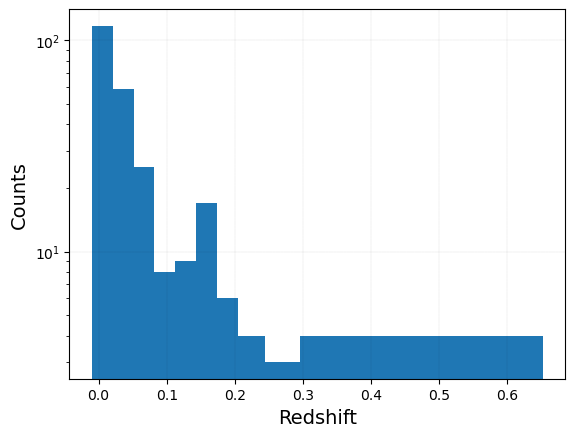

In [46]:
plt.hist(CIG_Sy['redshift'], bins=z_splits,log=True)
plt.xlabel('Redshift',fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.grid(color='k', linestyle='--', linewidth=0.05)
#plt.xscale('log')

Finally, we also save a file for all the galaxies, as in some cases this file is useful.

In [41]:
CIG_Sy.write(path_FINAL+'CIGPhotSy_EnergyBal_All.tbl', format='ascii',overwrite=True)

In [42]:
len(CIG_Sy)

252

-------------------------------------

## Notebook info:

In [43]:
%reload_ext watermark
%watermark -a "Jonhatan Bernal" -d -v -m
print('Specific Python packages')
%watermark -iv -w --packages astropy

Author: Jonhatan Bernal

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.12.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.15.0-73-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

Specific Python packages
astropy: 5.1

astropy   : 5.1
matplotlib: 3.7.1
numpy     : 1.21.5

Watermark: 2.3.1

